In [1]:

import re
import seaborn as sbn
import nltk
import tqdm as tqdm
import sqlite3
import pandas as pd
import numpy as np

import string
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words("english")
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from math import floor,ceil
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.svm import LinearSVC

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding


from gensim import summarization
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\15726\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\15726\anaconda3\envs\ds-1\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
review_data_or = pd.read_json('Clothing_Shoes_and_Jewelry_5.json',lines=True)

In [3]:
review_data_or.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [4]:
review_data_or.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278677 entries, 0 to 278676
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      278677 non-null  object
 1   asin            278677 non-null  object
 2   reviewerName    278225 non-null  object
 3   helpful         278677 non-null  object
 4   reviewText      278677 non-null  object
 5   overall         278677 non-null  int64 
 6   summary         278677 non-null  object
 7   unixReviewTime  278677 non-null  int64 
 8   reviewTime      278677 non-null  object
dtypes: int64(2), object(7)
memory usage: 19.1+ MB


In [5]:
review_data=review_data_or.drop(['reviewerID','asin','reviewerName','summary'],axis=1)


In [6]:
from datetime import datetime
current_date = datetime.now()
# Define a function to calculate the time difference in days
def calculate_time_difference(review_time):
    return (current_date - datetime.strptime(review_time, "%m %d, %Y")).days

# Apply the function to the 'reviewTime' column and replace it
review_data['Review_Interval_Days'] = review_data['reviewTime'].apply(calculate_time_difference)
review_data = review_data.drop(['reviewTime'],axis=1)


In [7]:
review_data['reviewText'] = review_data['reviewText'].astype('string')


In [8]:
review_data.head()

,helpful,reviewText,overall,unixReviewTime,Review_Interval_Days
0,"[0, 0]",This is a great tutu and at a really great pri...,5,1297468800,4629
1,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,1358553600,3922
2,"[0, 0]",What can I say... my daughters have it in oran...,5,1357257600,3937
3,"[0, 0]","We bought several tutus at once, and they are ...",5,1398556800,3459
4,"[0, 0]",Thank you Halo Heaven great product for Little...,5,1394841600,3502


In [9]:
reviews = review_data

reviews[['helpful','total']] = pd.DataFrame(reviews.helpful.values.tolist(), index=reviews.index)
############删掉没有评价是否有用的评论############################
reviews = reviews[reviews['total'] > 0]
#reviews["sentiment"] = reviews["overall"].apply(lambda score: 1 if score > 3 else 1)
reviews["usefulScore"] = (reviews["helpful"]/reviews["total"]).apply(lambda n: n if n > 0 else 0)
#.apply(lambda n: "useful" if n > 0.8 else "useless")

review_data = reviews.drop(['helpful','total'],axis=1)
review_data.head(10)


C:\Users\15726\AppData\Local\Temp\ipykernel_8748\3796216857.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews["usefulScore"] = (reviews["helpful"]/reviews["total"]).apply(lambda n: n if n > 0 else 0)


,reviewText,overall,unixReviewTime,Review_Interval_Days,usefulScore
9,For what I paid for two tutus is unbeatable an...,5,1349568000,4026,0.875000
13,Full and well stitched. This tutu is a beauti...,5,1361664000,3886,1.000000
22,"Prompt delivery, and it is exactly as describe...",4,1365552000,3841,0.500000
23,The minute I saw this my heart skipped a beat....,5,1383782400,3630,1.000000
24,Love this Jewelry Box so well put together ho...,5,1390089600,3557,0.000000
25,This products is great for anyone with a lot o...,5,1348444800,4039,0.500000
30,"The product itself is five stars, however the ...",4,1322956800,4334,0.980488
31,The first question was which computers to inst...,4,1285027200,4773,0.833333
32,"Okay, I admit it. I'm one of the millions of A...",5,1308182400,4505,0.846154
33,I bought this product a little over a year ago...,1,1348185600,4042,0.774194


In [10]:
a = review_data['overall'].value_counts()
print(a)

5    46636
4    17300
3    10670
2     6420
1     5995
Name: overall, dtype: int64


# Data Cleaning

In [11]:
count = 0
for i in review_data['reviewText']:
    if i == '':
        
        count = count+1
count

18

In [12]:
review_data = review_data[review_data['reviewText'] != '']

In [35]:
import nltk
#nlp = spacy.load("en_core_web_sm")
# 下载NLTK的punkt句子分割模型（只需要执行一次）
nltk.download('punkt')

from nltk.tokenize import sent_tokenize

def split_sentences(text):

  try:
   punctuation = ['.', '!', '?']
    
        # 去除句子末尾的空格
   text = text.rstrip()
    
     # 检查句末是否有标点符号
   if text[-1] not in punctuation:
        # 如果没有标点符号，就添加一个句号
      text = f'{text}.'
   sentences = sent_tokenize(text)

   return sentences
  except Exception as e:
    print(f"Error: {e}, Text: {text}")


review_data['reviewText']= review_data['reviewText'].apply(split_sentences)
#sample =split_sentences( review_data['reviewText'][9827])
#sample


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\15726\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [118]:

def data_clean( rev, remove_stopwords=True): 
    cre = []
    sen = []
    for i in rev:
        
        #去除特殊字符
        new_text = re.sub("[^a-zA-Z]"," ", i)
        #小写
        words = new_text.lower().split()
        # 去除停用词 the、a、an、and、in、on 
        if remove_stopwords:
            sts = set(stopwords.words("english"))
            words = [w for w in words if not w in sts]
        sen.append(' '.join(words))
    cre.append('. '.join(sen))
    cre = cre[0]
   
    punctuation = ['.', '!', '?']

    # 去除句子末尾的空格
    cre = cre.rstrip()

    # 检查句末是否有标点符号
    if cre[-1] not in punctuation:
    # 如果没有标点符号，就添加一个句号
        cre = f'{cre}.'
    #ary=[]
    #  the word "jumping" might be stemmed to "jump," and "running" might be stemmed to "run."
    #eng_stemmer = english_stemmer 
    #for word in words:
    #    ary.append(eng_stemmer.stem(word))
            
    return(cre)

In [119]:
review_data['Clean_review'] = review_data['reviewText'].apply(data_clean)

In [56]:
n=0
for review in review_data.reviewText: 
    if n <= 10:
        print(review)
        n = n+1

['For what I paid for two tutus is unbeatable anywhere!', 'I ordered a pink and turquios and they are vibrant and beautiful!', 'The tutu is very full!', 'Princess style!', 'Not cheaply made!', 'Not cheap materia!', 'Obviously someone made these with love and care!', 'I paid less than 7 bucks for a tutu I and I feel proud of my self for researching to the point of finding gold!Recommend 2-6 years!My daughter is two !', 'Wears size 4t and this skirt ( one size ) fit perfect and will probaly be able to accommodate her quickly growing waist for some time!']
['Full and well stitched.', 'This tutu is a beautiful purple color that looks just like the picture.', 'It looks just adorable on our little fairy.']
['Prompt delivery, and it is exactly as described.', "The only reason I did not give it 5 stars is because I haven't washed it yet- so I don't know how it will hold up... Other than that my little girl LOVES her tutus (we got one in light pink also), especially spinning and running in them

In [31]:
review_data = review_data[review_data['Clean_review'].notna() & (review_data['Clean_review'] != '')]

In [32]:
review_data.head()

,reviewText,overall,unixReviewTime,Review_Interval_Days,usefulScore,Clean_review
9,For what I paid for two tutus is unbeatable an...,5,1349568000,4026,0.875,paid two tutus unbeatable anywhere ordered pin...
13,Full and well stitched. This tutu is a beautif...,5,1361664000,3886,1.000,full well stitched tutu beautiful purple color...
22,"Prompt delivery, and it is exactly as describe...",4,1365552000,3841,0.500,prompt delivery exactly described reason give ...
23,The minute I saw this my heart skipped a beat....,5,1383782400,3630,1.000,minute saw heart skipped beat nice case sort c...
24,Love this Jewelry Box so well put together ho...,5,1390089600,3557,0.000,love jewelry box well put together holds plend...


In [ ]:
clean_reviewData = []
for rev in review_data['reviewText']:
    clean_reviewData.append( " ".join(data_clean(rev)))
    
clean_summaryData = []
for rev in review_data['summary']:
    clean_summaryData.append( " ".join(data_clean(rev)))


In [ ]:
Most_used_Words_Review =pd.Series(' '.join(clean_reviewData).lower().split()).value_counts()[:20]
print (Most_used_Words_Review)
Most_used_Words_Summary = pd.Series(' '.join(clean_summaryData).lower().split()).value_counts()[:20]
print (Most_used_Words_Summary)

fit        113687
wear       109582
size       104938
like       103105
look       100768
love        84159
shoe        83651
great       80015
comfort     68502
one         65797
would       63324
good        62002
well        61362
order       56103
color       54649
nice        52666
get         49619
realli      46268
perfect     45605
littl       42873
dtype: int64
great      34212
love       24990
nice       19123
good       16287
shoe       14096
fit        13195
comfort    12880
cute       11857
perfect     8659
size        7774
look        7321
qualiti     6785
small       6618
beauti      6175
like        6084
price       5970
pretti      5338
watch       5193
comfi       5156
shirt       5078
dtype: int64


## Preparing the data for further analysis, often for tasks like text classification, clustering, or other forms of text mining

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
#一个词至少要在4个文档中出现才会被考虑,最多只保留1000个特征（词）。
text_vectorizer = TfidfVectorizer(min_df=4, max_features = 1000)

test_vecor = text_vectorizer.fit_transform(clean_reviewData)
#通过 get_feature_names() 方法获取所有的特征（词）的名称，然后使用 idf_ 属性获取它们的逆文档频率（IDF），并将它们以词为键、IDF 值为值构建成一个字典 tfidf_vector。
tfidf_vector = dict(zip(text_vectorizer.get_feature_names(), text_vectorizer.idf_))
tfidf_vector

{'abl': 4.868584925156457,
 'absolut': 4.931326973533192,
 'accur': 5.959666800008726,
 'across': 5.7596007979157,
 'activ': 6.084829942962732,
 'actual': 4.305808260815983,
 'ad': 5.8050047420061714,
 'add': 5.333687339854151,
 'addit': 5.673392367433626,
 'adjust': 4.9074689830792995,
 'ador': 5.622829266579798,
 'adult': 6.541130784251654,
 'advertis': 6.140863669807178,
 'afford': 6.121433793235265,
 'afraid': 6.476477905517754,
 'age': 6.221264095245216,
 'ago': 5.355532533169175,
 'air': 6.03783573147607,
 'allow': 5.550287792579425,
 'almost': 4.606524646205736,
 'alon': 6.550322025427201,
 'along': 5.895767869554935,
 'alot': 6.464542554968482,
 'alreadi': 5.082707273325377,
 'also': 3.3396049700886326,
 'although': 5.088041757329389,
 'alway': 4.2235624370614975,
 'amaz': 5.12620184358702,
 'amazon': 4.183025296086981,
 'amount': 5.89865110076902,
 'ankl': 5.249529227220502,
 'annoy': 6.354700570684911,
 'anoth': 3.9565292263822682,
 'anymor': 6.379298275098872,
 'anyon': 4.93

# SMOG指数可读性分析
SMOG指数是一种用于评估文本可读性的指标，它考虑了一个文本中的多音节词的数量。SMOG代表了“Simple Measure of Gobbledygook”（即“混乱简单度量”），是由罗伯特·克拉斯特（Robert Gunning）于1952年提出的。它旨在提供一个简单但有效的方法来估计一段文本的阅读难易程度。

In [24]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86995 entries, 9 to 278676
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewText            86995 non-null  object 
 1   overall               86995 non-null  int64  
 2   unixReviewTime        86995 non-null  int64  
 3   Review_Interval_Days  86995 non-null  int64  
 4   usefulScore           86995 non-null  float64
 5   Clean_review          86995 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


In [120]:
sample_data = review_data.sample(n=10000, random_state=42)

In [121]:
sample_data

,reviewText,overall,unixReviewTime,Review_Interval_Days,usefulScore,Clean_review
92224,[I used this for my makeup and toiletry pack i...,5,1353888000,3976,0.500000,used makeup toiletry pack europe. pack travel ...
170079,[This is one of the most beautiful watches I h...,5,1365206400,3845,1.000000,one beautiful watches ever owned. quality outs...
198727,"[Not comfy., One size bigger than normal size....",2,1368489600,3807,1.000000,comfy. one size bigger normal size. slippery w...
208083,[These gloves do not keep your hands warm at a...,2,1383868800,3629,1.000000,gloves keep hands warm. moderate weather mid f...
222949,[These earrings are just as the picture shows....,5,1358812800,3919,1.000000,earrings picture shows. bought daughter. likes...
...,...,...,...,...,...,...
145492,[I'm a 9.5 and I got a 9.5 and they fit perfec...,5,1402876800,3409,0.666667,got fit perfectly. know stretch use regret get...
116235,[Looks much better than the photo here would i...,5,1371600000,3771,1.000000,looks much better photo would indicate googled...
143992,[I bought these for the Seahawks superbowl in ...,5,1395014400,3500,1.000000,bought seahawks superbowl nyc forecast suggest...
121875,[My girlfriend brought this itme thinking it w...,3,1354752000,3966,0.000000,girlfriend brought itme thinking great deal ho...


In [122]:
sample_data.reviewText

92224     [I used this for my makeup and toiletry pack i...
170079    [This is one of the most beautiful watches I h...
198727    [Not comfy., One size bigger than normal size....
208083    [These gloves do not keep your hands warm at a...
222949    [These earrings are just as the picture shows....
                                ...                        
145492    [I'm a 9.5 and I got a 9.5 and they fit perfec...
116235    [Looks much better than the photo here would i...
143992    [I bought these for the Seahawks superbowl in ...
121875    [My girlfriend brought this itme thinking it w...
40365     [Ihave had these boots in the construction fie...
Name: reviewText, Length: 10000, dtype: object

In [123]:
from textatistic import Textatistic

# 定义一个函数来计算SMOG指数
def calculate_smog(text):
    try:
        stats = Textatistic(text)
        return stats.smog_score
    except Exception as e:
        print(f"Error calculating SMOG for text: {e}/n{text}")
        return 0

# 示例用法
readability_scores = []

for i in sample_data.Clean_review:
    smog = calculate_smog(i)
    readability_scores.append(smog)

sample_data['Readability'] = readability_scores


Error calculating SMOG for text: Word to be hyphenated may have at most 100 characters./npuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuurrrrrrrrrrrrrfect. roll fits comfortable leg rubbing. love love love.


## Test of SentimentIntensity Analysis极性分析


In [124]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
#sample_review = review_data.reviewText[:10]
Review_Polarity = []
for test in sample_data.Clean_review:
    ss = analyser.polarity_scores(test) #极性分析
    #for k in sorted(ss):
        #print('{0}: {1}, '.format(k, ss[k]))
    Review_Polarity.append(ss['compound'])
    #print(test)
Review_Polarity[:10]
sample_data['Polarity'] = Review_Polarity

# 主观性分析 TextBlob


In [125]:
from textblob import TextBlob, Word, Blobber
sample_data['Subjectivity'] = sample_data['Clean_review'].apply(lambda x: TextBlob(x).sentiment[1])



In [127]:
sample_data = sample_data.drop(['reviewText','Clean_review'],axis=1)

In [128]:
sample_data

,overall,unixReviewTime,Review_Interval_Days,usefulScore,Readability,Polarity,Subjectivity
92224,5,1353888000,3976,0.500000,5.985473,0.7783,0.638095
170079,5,1365206400,3845,1.000000,7.168622,0.9001,0.958333
198727,2,1368489600,3807,1.000000,5.985473,0.5719,0.670000
208083,2,1383868800,3629,1.000000,6.742158,-0.4019,0.450000
222949,5,1358812800,3919,1.000000,3.129100,0.4215,0.350000
...,...,...,...,...,...,...,...
145492,5,1402876800,3409,0.666667,7.793538,0.9808,0.700000
116235,5,1371600000,3771,1.000000,6.427356,0.9746,0.357051
143992,5,1395014400,3500,1.000000,7.168622,0.8555,0.342857
121875,3,1354752000,3966,0.000000,8.841846,0.6249,0.883333


# distribution of usefulScore is heavily skewed towards 0

In [ ]:
sample_data.describe()

,overall,unixReviewTime,Review_Interval_Days,usefulScore,Readability,Polarity,Subjectivity
count,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.070300,1.361367e+09,3889.435700,0.773324,6.551588,0.659694,0.554693
std,1.245276,3.699698e+07,428.205787,0.350015,2.098977,0.455553,0.143320
min,1.000000,1.102464e+09,3381.000000,0.000000,0.000000,-0.992100,0.000000
25%,3.000000,1.352333e+09,3599.000000,0.666667,5.565023,0.587800,0.469504
50%,5.000000,1.369786e+09,3792.000000,1.000000,6.742158,0.865800,0.550383
75%,5.000000,1.386461e+09,3994.000000,1.000000,7.793538,0.948400,0.638889
max,5.000000,1.405296e+09,6886.000000,1.000000,21.194390,0.999800,1.000000


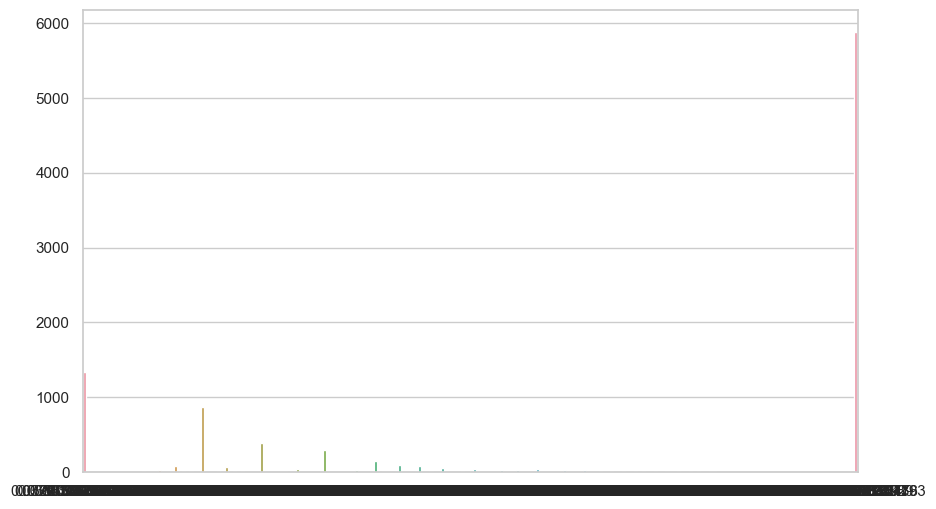

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
b = sample_data.usefulScore.value_counts()
b
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=b.index, y=b.values)

plt.show()

In [ ]:
b

1.000000    5885
0.000000    1331
0.500000     868
0.666667     386
0.750000     296
            ... 
0.642857       1
0.958678       1
0.074074       1
0.964286       1
0.545455       1
Name: usefulScore, Length: 197, dtype: int64

# 归一化

In [129]:
from sklearn.preprocessing import MinMaxScaler

# 选择需要归一化的特征
features_to_normalize = ['overall', 'unixReviewTime', 'Review_Interval_Days', 'Readability', 'Polarity']

# 初始化MinMaxScaler
scaler = MinMaxScaler()

# 对特征进行归一化
sample_data[features_to_normalize] = scaler.fit_transform(sample_data[features_to_normalize])

# 输出归一化后的数据
print(sample_data)


        overall  unixReviewTime  Review_Interval_Days  usefulScore  \
92224      1.00        0.828588              0.171412     0.500000   
170079     1.00        0.865888              0.134112     1.000000   
198727     0.25        0.876708              0.123292     1.000000   
208083     0.25        0.927392              0.072608     1.000000   
222949     1.00        0.844818              0.155182     1.000000   
...         ...             ...                   ...          ...   
145492     1.00        0.990034              0.009966     0.666667   
116235     1.00        0.886959              0.113041     1.000000   
143992     1.00        0.964123              0.035877     1.000000   
121875     0.50        0.831435              0.168565     0.000000   
40365      1.00        0.903474              0.096526     1.000000   

        Readability  Polarity  Subjectivity  
92224      0.261162  0.887020      0.638095  
170079     0.312786  0.949287      0.958333  
198727     0.261162  

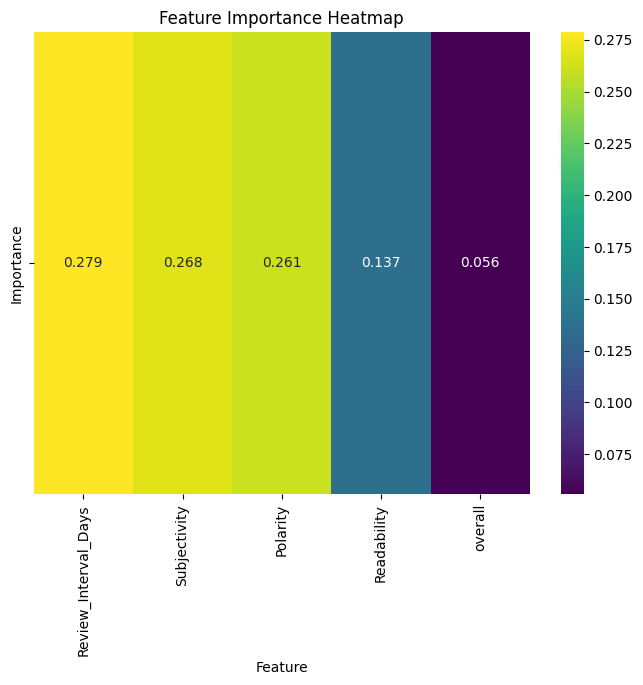

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Assuming 'data' contains the features and labels (overall, Review_Interval_Days, Readability, Polarity)
# X contains the features, y contains the labels
X = sample_data[['overall', 'Review_Interval_Days', 'Readability', 'Polarity','Subjectivity']].values
y = sample_data['usefulScore'].values

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X, y)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame with feature names and their importances
importance_df = pd.DataFrame({'Feature': ['overall', 'Review_Interval_Days', 'Readability', 'Polarity','Subjectivity'],
                              'Importance': feature_importances})


# Create the heatmap
plt.figure(figsize=(8, 6))
heatmap_data = importance_df.set_index('Feature')['Importance'].sort_values(ascending=False).to_frame().T
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='.3f')
plt.title('Feature Importance Heatmap')
plt.show()

In [131]:
# 不用交叉验证，没必要，时间长，结果差不多
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# Assuming 'data' contains the features and labels (overall, Review_Interval_Days, Readability, Polarity)
# X contains the features, y contains the labels
X = sample_data[['overall', 'Review_Interval_Days', 'Readability', 'Polarity','Subjectivity']].values
y = sample_data['usefulScore'].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Assuming 'usefulScore' is a regression task
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
##0.1567 --->0.11603 ---> 0.1128

Epoch 1/50
250/250 [==============================] - 1s 2ms/step - loss: 0.1589 - val_loss: 0.1197
Epoch 2/50
250/250 [==============================] - 0s 2ms/step - loss: 0.1198 - val_loss: 0.1142
Epoch 3/50
250/250 [==============================] - 0s 2ms/step - loss: 0.1178 - val_loss: 0.1141
Epoch 4/50
250/250 [==============================] - 0s 2ms/step - loss: 0.1162 - val_loss: 0.1119
Epoch 5/50
250/250 [==============================] - 0s 2ms/step - loss: 0.1163 - val_loss: 0.1138
Epoch 6/50
250/250 [==============================] - 0s 2ms/step - loss: 0.1166 - val_loss: 0.1121
Epoch 7/50
250/250 [==============================] - 0s 2ms/step - loss: 0.1153 - val_loss: 0.1101
Epoch 8/50
250/250 [==============================] - 0s 2ms/step - loss: 0.1150 - val_loss: 0.1119
Epoch 9/50
250/250 [==============================] - 0s 2ms/step - loss: 0.1153 - val_loss: 0.1141
Epoch 10/50
250/250 [==============================] - 0s 2ms/step - loss: 0.1149 - val_loss: 0.1113

# 阈值判断

In [137]:
from keras.models import Sequential
from keras.layers import Dense
threshold = 0.4
# Assuming X_train and y_train are your features and labels
# Convert usefulScore to binary labels
y_train_binary = (y_train > threshold).astype(int)


In [138]:
######阈值？？？？？？？？？？？？？？useful>0.7 auc = 0.89
# Create a new model
model1 = Sequential()
model1.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

# Compile the model with binary cross entropy loss
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model1.fit(X_train, y_train_binary, epochs=10, batch_size=32, verbose=1)

# Assuming X_test is your test data
# Convert usefulScore to binary labels for test data
y_test_binary = (y_test > threshold).astype(int)

# Evaluate the model
#y_pred = model1.predict(X_test)
accuracy = model1.evaluate(X_test, y_test_binary)[1]
print(f'Accuracy: {accuracy}')
##0.859499 ---> 0.8644 dataclean

Epoch 1/10
250/250 [==============================] - 3s 3ms/step - loss: 0.4379 - accuracy: 0.8446
Epoch 2/10
250/250 [==============================] - 1s 6ms/step - loss: 0.4036 - accuracy: 0.8547
Epoch 3/10
250/250 [==============================] - 1s 3ms/step - loss: 0.3998 - accuracy: 0.8547
Epoch 4/10
250/250 [==============================] - 1s 3ms/step - loss: 0.3980 - accuracy: 0.8547
Epoch 5/10
250/250 [==============================] - 1s 4ms/step - loss: 0.3966 - accuracy: 0.8547
Epoch 6/10
250/250 [==============================] - 1s 5ms/step - loss: 0.3961 - accuracy: 0.8547
Epoch 7/10
250/250 [==============================] - 1s 5ms/step - loss: 0.3954 - accuracy: 0.8547
Epoch 8/10
250/250 [==============================] - 1s 5ms/step - loss: 0.3947 - accuracy: 0.8550
Epoch 9/10
250/250 [==============================] - 2s 6ms/step - loss: 0.3943 - accuracy: 0.8550
Epoch 10/10
63/63 [==============================] - 0s 2ms/step - loss: 0.3861 - accuracy: 0.8645
A

In [139]:
y_pred =  model1.predict(X_test)
y_pred_thresholded = (y_pred > threshold).astype(int)

63/63 [==============================] - 0s 3ms/step


Epoch 1/10
250/250 [==============================] - 2s 3ms/step - loss: 0.4425 - accuracy: 0.8440
Epoch 2/10
250/250 [==============================] - 1s 3ms/step - loss: 0.4028 - accuracy: 0.8547
Epoch 3/10
250/250 [==============================] - 1s 4ms/step - loss: 0.3999 - accuracy: 0.8547
Epoch 4/10
250/250 [==============================] - 1s 4ms/step - loss: 0.3980 - accuracy: 0.8547
Epoch 5/10
250/250 [==============================] - 1s 3ms/step - loss: 0.3968 - accuracy: 0.8547
Epoch 6/10
250/250 [==============================] - 1s 3ms/step - loss: 0.3963 - accuracy: 0.8549
Epoch 7/10
250/250 [==============================] - 1s 4ms/step - loss: 0.3955 - accuracy: 0.8546
Epoch 8/10
250/250 [==============================] - 1s 4ms/step - loss: 0.3948 - accuracy: 0.8549
Epoch 9/10
250/250 [==============================] - 1s 4ms/step - loss: 0.3948 - accuracy: 0.8544
Epoch 10/10
63/63 [==============================] - 0s 3ms/step
Epoch 1/10
250/250 [===============

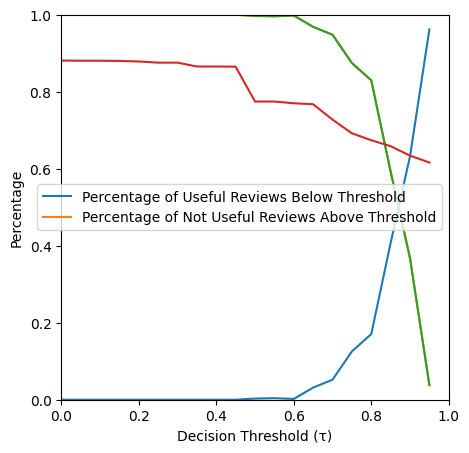

In [159]:

import matplotlib.pyplot as plt



# Generate a range of decision thresholds τ (e.g., from 0 to 1 with step 0.1)
thresholds = [i/20 for i in range(20)]

# Placeholder for results
percentage_useful = []
percentage_not_useful = []
precision_list = []
recall_list = []


# Assuming you have y_true and y_pred, where y_true contains the true labels and y_pred contains the predicted scores.

for threshold in thresholds:
    y_test_binary = (y_test > threshold).astype(int)
    # Create a new model
    model1 = Sequential()
    model1.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model1.add(Dense(1, activation='sigmoid'))

    # Compile the model with binary cross entropy loss
    model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    model1.fit(X_train, y_train_binary, epochs=10, batch_size=32, verbose=1)
    
    y_pred =  model1.predict(X_test)
    y_pred_thresholded = (y_pred > threshold).astype(int)
    
# Reshape y_train if needed
    #y_test = y_test.reshape(-1, 1)


    # Calculate precision and recall
    tp = ((y_test_binary == 1) & (y_pred_thresholded == 1)).sum()
    fp = ((y_test_binary == 0) & (y_pred_thresholded == 1)).sum()
    fn = ((y_test_binary == 1) & (y_pred_thresholded == 0)).sum()
    tn = ((y_test_binary == 0) & (y_pred_thresholded == 0)).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    useful = fn / (tp + fn)
    notuseful = fp / (tn + fp)
        # Calculate percentages
    percentage_useful.append(useful)
    percentage_not_useful.append(notuseful)

    
    precision_list.append(precision)
    recall_list.append(recall)

# Plotting
plt.figure(figsize=(5,5))
plt.plot(thresholds, percentage_useful, label="Percentage of Useful Reviews Below Threshold")
plt.plot(thresholds, percentage_not_useful, label="Percentage of Not Useful Reviews Above Threshold")
plt.plot(thresholds,recall_list)
plt.plot(thresholds,precision_list)
plt.ylim((0,1))
plt.xlim((0,1))
plt.xlabel("Decision Threshold (τ)")
plt.ylabel("Percentage")
plt.legend()



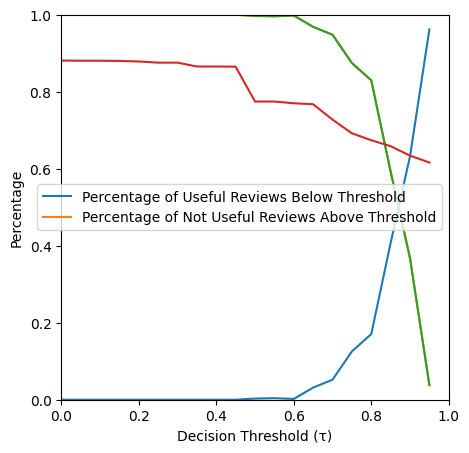

In [162]:
# Plotting
plt.figure(figsize=(5,5))
plt.plot(thresholds, percentage_useful, label="Percentage of Useful Reviews Below Threshold")
plt.plot(thresholds, percentage_not_useful, label="Percentage of Not Useful Reviews Above Threshold")
plt.plot(thresholds,recall_list)
plt.plot(thresholds,precision_list)
plt.ylim((0,1))
plt.xlim((0,1))
plt.xlabel("Decision Threshold (τ)")
plt.ylabel("Percentage")
plt.legend()


In [164]:
percentage_useful

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.003,
 0.004,
 0.002,
 0.0315,
 0.052,
 0.1255,
 0.1705,
 0.4075,
 0.6325,
 0.962]

In [147]:
precision_list


[0.881,
 0.8805,
 0.8785,
 0.8755,
 0.8655,
 0.7745,
 0.77,
 0.7275,
 0.674,
 0.634,
 nan]

In [148]:
recall_list

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9975, 0.9755, 0.8115, 0.21, nan]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


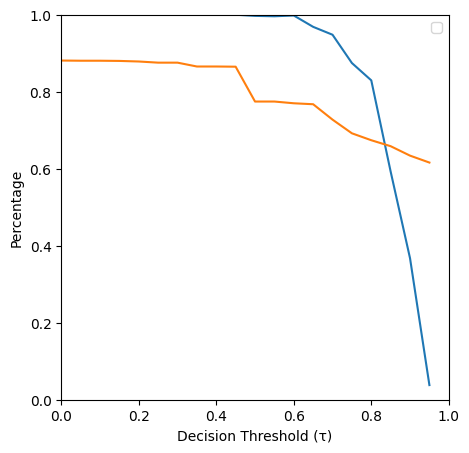

In [161]:
# Generate a range of decision thresholds τ (e.g., from 0 to 1 with step 0.1)
thresholds = [i/20 for i in range(20)]

plt.figure(figsize=(5,5))
#plt.plot(thresholds, percentage_useful, label="Percentage of Useful Reviews Below Threshold")
#plt.plot(thresholds, percentage_not_useful, label="Percentage of Not Useful Reviews Above Threshold")
plt.plot(thresholds,recall_list)
plt.plot(thresholds,precision_list)
plt.ylim((0,1))
plt.xlim((0,1))
plt.xlabel("Decision Threshold (τ)")
plt.ylabel("Percentage")
plt.legend()

In [ ]:
y_pred_thresholded

array([[0.85403275],
       [0.83856124],
       [0.8402736 ],
       ...,
       [0.8505688 ],
       [0.852949  ],
       [0.84438086]], dtype=float32)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# Assuming 'data' contains the features and labels (overall, Review_Interval_Days, Readability, Polarity)
# X contains the features, y contains the labels
features = ['overall', 'Review_Interval_Days', 'Readability', 'Polarity','Subjectivity']
outcome = []
y = sample_data['usefulScore'].values
for i in features:
    X = sample_data[[i]].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build the neural network model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)  # Assuming 'usefulScore' is a regression task
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

    # Evaluate the model
    y_pred = model.predict(X_test)


    mse = mean_squared_error(y_test, y_pred)
    
    
    ######阈值？？？？？？？？？？？？？？useful>0.7 auc = 0.89
    # Create a new model
    model2 = Sequential()
    model2.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model2.add(Dense(1, activation='sigmoid'))

    # Compile the model with binary cross entropy loss
    model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Assuming X_train and y_train are your features and labels
    # Convert usefulScore to binary labels
    y_train_binary = (y_train > threshold).astype(int)

    # Train the model
    model2.fit(X_train, y_train_binary, epochs=10, batch_size=32, verbose=1)

    # Assuming X_test is your test data
    # Convert usefulScore to binary labels for test data
    y_test_binary = (y_test > threshold).astype(int)

    # Evaluate the model
    accuracy = model2.evaluate(X_test, y_test_binary)[1]
    outcome.append(f'Mean Squared Error for {i}: {mse} ,Accuracy: {accuracy}')
outcome




Epoch 1/50
250/250 [==============================] - 2s 3ms/step - loss: 0.1969 - val_loss: 0.1240
Epoch 2/50
250/250 [==============================] - 0s 2ms/step - loss: 0.1240 - val_loss: 0.1161
Epoch 3/50
250/250 [==============================] - 1s 2ms/step - loss: 0.1207 - val_loss: 0.1141
Epoch 4/50
250/250 [==============================] - 1s 3ms/step - loss: 0.1204 - val_loss: 0.1141
Epoch 5/50
250/250 [==============================] - 1s 3ms/step - loss: 0.1203 - val_loss: 0.1154
Epoch 6/50
250/250 [==============================] - 1s 3ms/step - loss: 0.1206 - val_loss: 0.1190
Epoch 7/50
250/250 [==============================] - 1s 3ms/step - loss: 0.1204 - val_loss: 0.1142
Epoch 8/50
250/250 [==============================] - 1s 3ms/step - loss: 0.1205 - val_loss: 0.1138
Epoch 9/50
250/250 [==============================] - 1s 3ms/step - loss: 0.1205 - val_loss: 0.1139
Epoch 10/50
250/250 [==============================] - 1s 3ms/step - loss: 0.1203 - val_loss: 0.1166

['Mean Squared Error for overall: 0.11421848563045928 ,Accuracy: 0.859499990940094',
 'Mean Squared Error for Review_Interval_Days: 0.11655410813972511 ,Accuracy: 0.859499990940094',
 'Mean Squared Error for Readability: 0.11560422779994574 ,Accuracy: 0.859499990940094',
 'Mean Squared Error for Polarity: 0.11705979347620382 ,Accuracy: 0.859499990940094',
 'Mean Squared Error for Subjectivity: 0.11629823427067197 ,Accuracy: 0.859499990940094']

In [167]:


# Assuming 'data' contains the features and labels (overall, Review_Interval_Days, Readability, Polarity)
# X contains the features, y contains the labels
features = ['overall', 'Review_Interval_Days', 'Readability', 'Polarity','Subkectivity']
outcome = []
threshold = 0.4
for i in features:
    # ...
    # Your existing code for feature preprocessing

    # Create a new model
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with binary cross entropy loss
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Convert usefulScore to binary labels
    y_train_binary = (y_train > threshold).astype(int)

    # Train the model
    model.fit(X_train, y_train_binary, epochs=10, batch_size=32, verbose=1)

    # Assuming X_test is your test data
    # Convert usefulScore to binary labels for test data
    y_test_binary = (y_test > threshold).astype(int)

    # Evaluate the model
    accuracy = model.evaluate(X_test, y_test_binary)[1]

    outcome.append(f'Accuracy for {i}: {accuracy}')
outcome

Epoch 1/10
250/250 [==============================] - 3s 4ms/step - loss: 0.4396 - accuracy: 0.8506
Epoch 2/10
250/250 [==============================] - 1s 3ms/step - loss: 0.4037 - accuracy: 0.8547
Epoch 3/10
250/250 [==============================] - 1s 3ms/step - loss: 0.3997 - accuracy: 0.8547
Epoch 4/10
250/250 [==============================] - 1s 4ms/step - loss: 0.3982 - accuracy: 0.8547
Epoch 5/10
250/250 [==============================] - 1s 4ms/step - loss: 0.3967 - accuracy: 0.8547
Epoch 6/10
250/250 [==============================] - 1s 5ms/step - loss: 0.3959 - accuracy: 0.8547
Epoch 7/10
250/250 [==============================] - 1s 6ms/step - loss: 0.3951 - accuracy: 0.8553
Epoch 8/10
250/250 [==============================] - 1s 5ms/step - loss: 0.3947 - accuracy: 0.8549
Epoch 9/10
250/250 [==============================] - 1s 4ms/step - loss: 0.3949 - accuracy: 0.8539
Epoch 10/10
63/63 [==============================] - 1s 3ms/step - loss: 0.3836 - accuracy: 0.8655
E

['Accuracy for overall: 0.8654999732971191',
 'Accuracy for Review_Interval_Days: 0.8644999861717224',
 'Accuracy for Readability: 0.8665000200271606',
 'Accuracy for Polarity: 0.8644999861717224',
 'Accuracy for Subkectivity: 0.8640000224113464']

## Cluster


In [ ]:
from sklearn.cluster import MiniBatchKMeans

clusters = 20
kmeans_model = MiniBatchKMeans(n_clusters=clusters, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
kmodel = kmeans_model.fit(test_vecor)
kmodel_clusters = kmodel.predict(test_vecor)
kmodel_distances = kmodel.transform(test_vecor)
centroids = kmodel.cluster_centers_.argsort()[:, ::-1]
values = text_vectorizer.get_feature_names()
for i in range(clusters):
    print("Cluster %d:" % i)
    for j in centroids[i, :5]:
        print(' %s' % values[j])
    print()

Cluster 0:
 shoe
 comfort
 wear
 walk
 great

Cluster 1:
 ring
 look
 finger
 love
 stone

Cluster 2:
 bra
 bras
 support
 cup
 comfort

Cluster 3:
 love
 necklac
 cute
 color
 bracelet

Cluster 4:
 gift
 love
 bought
 christma
 great

Cluster 5:
 comfort
 wear
 sock
 fit
 great

Cluster 6:
 look
 like
 one
 would
 nice

Cluster 7:
 size
 order
 small
 fit
 wear

Cluster 8:
 perfect
 fit
 love
 color
 great

Cluster 9:
 well
 great
 fit
 made
 color

Cluster 10:
 larg
 size
 fit
 medium
 order

Cluster 11:
 boot
 dress
 wear
 look
 fit

Cluster 12:
 pair
 comfort
 shoe
 wear
 love

Cluster 13:
 shirt
 fit
 like
 wear
 great

Cluster 14:
 feet
 shoe
 foot
 toe
 wide

Cluster 15:
 watch
 band
 time
 look
 wrist

Cluster 16:
 pant
 leg
 waist
 fit
 short

Cluster 17:
 good
 qualiti
 price
 look
 fit

Cluster 18:
 bag
 pocket
 wallet
 carri
 use

Cluster 19:
 husband
 love
 bought
 fit
 wear



# preprocess text data for a machine learning #

# 使用TF-IDF将文本转化为特征向量

In [ ]:
test_reviewText = review_data.reviewText
test_Ratings = review_data.overall

#  words occurring in more than 80% of the documents will be ignored.
text_vectorizer = TfidfVectorizer(max_df=.8)


#TfidfVectorizer 是scikit-learn库中用于将文本数据转换为TF-IDF特征表示的工具。
# TF-IDF（Term Frequency-Inverse Document Frequency）
# 是一种用于衡量一个词在一个文档中的重要性以及在整个文集中的重要性的统计方法。


# learns the vocabulary and computes the IDF values
text_vectorizer.fit(test_reviewText)

#convert ratings to one-hot encode. 
def rate(r):
    ary2 = []
    for rating in r:
        tv = [0,0,0,0,0]
        tv[rating-1] = 1
        ary2.append(tv)
    return np.array(ary2)


## ML in NN神经网络 ##

In [ ]:
# matrix X where each row represents a review, and each column represents a word in the vocabulary.
X = 
# y是helpfulness
y = rate(test_Ratings.values)


In [ ]:
X.head()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

model = Sequential()
model.add(Dense(128,input_dim=X_train.shape[1]))
model.add(Dense(5,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=10,batch_size=32,verbose=1)
model.evaluate(X_test,y_test)[1]


Epoch 1/10
50/50 [==============================] - 10s 158ms/step - loss: 1.1861 - accuracy: 0.6281 - val_loss: 0.9789 - val_accuracy: 0.6725
Epoch 2/10
50/50 [==============================] - 5s 98ms/step - loss: 0.9638 - accuracy: 0.6369 - val_loss: 0.9228 - val_accuracy: 0.6725
Epoch 3/10
50/50 [==============================] - 6s 127ms/step - loss: 0.8432 - accuracy: 0.6488 - val_loss: 0.8712 - val_accuracy: 0.6825
Epoch 4/10
50/50 [==============================] - 5s 104ms/step - loss: 0.7268 - accuracy: 0.7119 - val_loss: 0.8488 - val_accuracy: 0.6700
Epoch 5/10
50/50 [==============================] - 5s 90ms/step - loss: 0.6199 - accuracy: 0.7856 - val_loss: 0.8315 - val_accuracy: 0.6800
Epoch 6/10
50/50 [==============================] - 4s 88ms/step - loss: 0.5188 - accuracy: 0.8356 - val_loss: 0.8326 - val_accuracy: 0.6925
Epoch 7/10
50/50 [==============================] - 4s 85ms/step - loss: 0.4270 - accuracy: 0.8913 - val_loss: 0.8404 - val_accuracy: 0.6950
Epoch 8/1

0.6575000286102295